## TUTORIAL 02 - Elastic block problem
**_Keywords: POD-Galerkin method, vector problem_**

### 1. Introduction
In this Tutorial we consider a linear elasticity problem in a two-dimensional square domain $\Omega$.

The domain is partioned in nine square subdomains.

Parameters of this problem include Young moduli of each subdomain, as well as lateral traction on the right side of square. In particular:
* the ratio between the Young modulus of the each subdomain $\Omega_{p+1}$, $p=0,\dots,7$ and the top-right subdomain $\Omega_9$ is denoted by $\mu_p$, being

$$
\mu_p \in \left[1, 100\right] \qquad \text{for }p=0,\dots,7.
$$

* the horizontal tractions on each boundary $\Gamma_{p-6}$, $p=8,\dots,10$, being

$$
\mu_p \in \left[-1,1\right] \qquad \text{for } p=8,\dots, 10.
$$

For what concerns the remaining boundaries, the left boundary $\Gamma_6$ is clamped, while the top and bottom boundaries $\Gamma_1 \cup \Gamma_5$ are traction free.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0, \cdots,\mu_{10})
$$
on the parameter domain
$$
\mathbb{P}=[1,100]^8\times[-1,1]^3.
$$

In order to obtain a faster approximation of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Parametrized formulation

Let $\boldsymbol{u}(\boldsymbol{\mu})$ be the displacement in the domain $\Omega$.

In each subdomain $\Omega_{p+1}$, $p=0,\dots,7$, we assume an isotropic linear elastic material, characterized by the following Lamè constants for plane strain
$$\lambda_1(\mu_p) = \frac{\mu_p \nu}{(1+\nu)(1-2\nu)},$$
$$\lambda_2(\mu_p) = \frac{\mu_p}{2(1+\nu)},$$
for $\nu=0.30$, with the following Piola-Kirchhoff tensor

$$
\boldsymbol{\pi}(\boldsymbol{u}; \mu_p) = 
\lambda_1(\mu_p)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\lambda_2(\mu_p)\;\nabla_{S}\boldsymbol{u}
$$
where $\nabla_{S}$ denotes the symmetric part of the gradient.

Similarly, the Piola-Kirchhoff tensor in the top right subdomain $\Omega_9$ is given by $\boldsymbol{\pi}(\boldsymbol{u}; 1)$.

Thus, the Piola-Kirchhoff tensor on the domain $\Omega$ can be obtained as
$$
\boldsymbol{P}(\boldsymbol{u}; \boldsymbol{\mu}) = 
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u}
$$
where
$$
\Lambda_1(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_1(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_1(1) \mathbb{1}_{\Omega_{9}}
$$
$$
\Lambda_2(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_2(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_2(1) \mathbb{1}_{\Omega_{9}}
$$

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $\boldsymbol{u}(\boldsymbol{\mu})$ such that
$$
\begin{cases}
	- \text{div} \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{1},\\
	\boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mu_p \mathbf{n} & \text{on } \Gamma_{p-6}, p=8,\dots, 10,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{5},\\
	\boldsymbol{u}(\boldsymbol{\mu}) = \boldsymbol{0} & \text{on } \Gamma_{6},\\
\end{cases}
$$
<br>

where $\mathbf{n}$ denotes the outer normal to the boundary $\partial\Omega$.

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{\boldsymbol{v}\in H^1(\Omega; \mathbb{R}^2) : \boldsymbol{v}|_{\Gamma_{6}}=\boldsymbol{0}\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu})=\int_{\Omega}
\left\{
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v}
\right\}  d\boldsymbol{x}
$$,
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(\boldsymbol{v}; \boldsymbol{\mu})= \sum_{p=8}^{10} \mu_p \int_{\Gamma_{p-6}} \boldsymbol{v} \cdot \mathbf{n} \ ds$$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward. Indeed, owing to the definitions of $\Lambda_1(\boldsymbol{\mu})$ and $\Lambda_2(\boldsymbol{\mu})$, we have:
$$
a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu}) = \sum_{p=0}^7 \underbrace{\mu_{\color{red} p}}_{\Theta^{a}_{\color{red} p}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red}{p + 1}}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} p}(\boldsymbol{u}, \boldsymbol{v})} +\\
\underbrace{1}_{\Theta^{a}_{\color{red} 8}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red} 9}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} 8}(\boldsymbol{u}, \boldsymbol{v})}\\
$$
$$
f(\boldsymbol{v}; \boldsymbol{\mu}) = 
\sum_{p=8}^{10} \underbrace{\mu_{\color{red} p}}_{\Theta^{f}_{\color{red}{p-8}}(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{\color{red}{p-6}}} \boldsymbol{v} \cdot \mathbf{n}}_{f_{\color{red}{p-8}}(\boldsymbol{v})}.
$$

We will implement the numerical discretization of the problem in the class
```
class ElasticBlock(EllipticCoerciveProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(\boldsymbol{u}, \boldsymbol{v})$ and linear forms $f_*(\boldsymbol{v})$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ElasticBlock(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # ...
        self.f = Constant((1.0, 0.0))
        self.E = 1.0
        self.nu = 0.3
        self.lambda_1 = self.E * self.nu / ((1.0 + self.nu) * (1.0 - 2.0 * self.nu))
        self.lambda_2 = self.E / (2.0 * (1.0 + self.nu))

    # Return custom problem name
    def name(self):
        return "ElasticBlock"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = mu[1]
            theta_a2 = mu[2]
            theta_a3 = mu[3]
            theta_a4 = mu[4]
            theta_a5 = mu[5]
            theta_a6 = mu[6]
            theta_a7 = mu[7]
            theta_a8 = 1.
            return (theta_a0, theta_a1, theta_a2, theta_a3, theta_a4, theta_a5, theta_a6, theta_a7, theta_a8)
        elif term == "f":
            theta_f0 = mu[8]
            theta_f1 = mu[9]
            theta_f2 = mu[10]
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = self.elasticity(u, v) * dx(1)
            a1 = self.elasticity(u, v) * dx(2)
            a2 = self.elasticity(u, v) * dx(3)
            a3 = self.elasticity(u, v) * dx(4)
            a4 = self.elasticity(u, v) * dx(5)
            a5 = self.elasticity(u, v) * dx(6)
            a6 = self.elasticity(u, v) * dx(7)
            a7 = self.elasticity(u, v) * dx(8)
            a8 = self.elasticity(u, v) * dx(9)
            return (a0, a1, a2, a3, a4, a5, a6, a7, a8)
        elif term == "f":
            ds = self.ds
            f = self.f
            f0 = inner(f, v) * ds(2)
            f1 = inner(f, v) * ds(3)
            f2 = inner(f, v) * ds(4)
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant((0.0, 0.0)), self.boundaries, 6)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(u, v) * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

    # Auxiliary function to compute the elasticity bilinear form
    def elasticity(self, u, v):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        return 2.0 * lambda_2 * inner(sym(grad(u)), sym(grad(v))) + lambda_1 * tr(sym(grad(u))) * tr(sym(grad(v)))

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/elastic_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/elastic_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/elastic_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = VectorFunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ElasticBlock class

In [5]:
problem = ElasticBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0)
]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(80)
reduction_method.set_tolerance(2e-6)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(500)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train Greedy PDNN-PINN

Increasing the number of parameters for which we compute residuals each iteration may help to reduce the increase in validation loss during training. It also reduces the increase in training loss as we add points to the training set. However, the number required to improve results begins to be too much for memory and speed. Also, there is much better improvement when we also increase the amount of new training data per iteration. This seems much more important.

In [8]:
input_normalization_pdnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.MinMaxNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=100)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=1000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

pdnn_net.VERBOSE = False

Initial training...
0 0.07995635452880799 	Loss(validation) = 0.08173945360149144
100 0.030412774630422905 	Loss(validation) = 0.03946706675238809
200 0.028214439265135945 	Loss(validation) = 0.038647029960724
300 0.02225795719146667 	Loss(validation) = 0.038286439363722474
400 0.017137925514171766 	Loss(validation) = 0.0398185630789354
500 0.013521645482765951 	Loss(validation) = 0.04218832006330118
600 0.01097092082686316 	Loss(validation) = 0.044838508736232255
700 0.009124691539367364 	Loss(validation) = 0.04712713996929173
800 0.007718251691929468 	Loss(validation) = 0.04913595758325021
900 0.006595601022973665 	Loss(validation) = 0.051021908707669136
Beginning data augmentation cycles...
Assembling residuals...


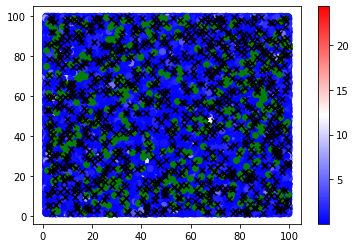

1000 0.03497530926088509 	Loss(validation) = 0.038008247791893254
1100 0.030157277031323627 	Loss(validation) = 0.03889531177150643
1200 0.027006621940979594 	Loss(validation) = 0.03942573938977136
1300 0.024743062273057073 	Loss(validation) = 0.03972321349600895
1400 0.023050782006197156 	Loss(validation) = 0.04000851017216634
1500 0.02175577608908795 	Loss(validation) = 0.0404173265790321
1600 0.020602270899968047 	Loss(validation) = 0.04082171131251098
1700 0.019674884297431826 	Loss(validation) = 0.04128469637361544
1800 0.018923599815416376 	Loss(validation) = 0.04180922477050461
1900 0.01818640514952986 	Loss(validation) = 0.0422037389010267
Assembling residuals...


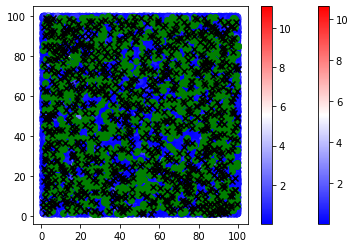

2000 0.03515126369085251 	Loss(validation) = 0.037967913817510975
2100 0.032587815908759886 	Loss(validation) = 0.03796470626852047
2200 0.030724201924432194 	Loss(validation) = 0.03800422561620779
2300 0.02935525296816977 	Loss(validation) = 0.038100405463453946
2400 0.02788174171134081 	Loss(validation) = 0.038018404142473275
2500 0.026776664952796122 	Loss(validation) = 0.038053187275527166
2600 0.025982142429783667 	Loss(validation) = 0.03815395921938005
2700 0.02496804892168201 	Loss(validation) = 0.03818590202717228
2800 0.024232605415483402 	Loss(validation) = 0.03829756430004923
2900 0.023580636599029405 	Loss(validation) = 0.03843295950074298
Assembling residuals...


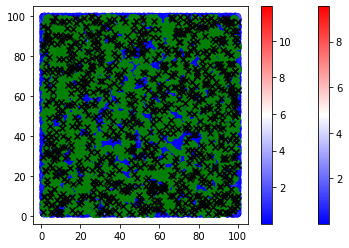

3000 0.0342530923706523 	Loss(validation) = 0.036750708409501565
3100 0.032542758023344616 	Loss(validation) = 0.03689646455041386
3200 0.031040079813755516 	Loss(validation) = 0.036810553529835595
3300 0.029957800923596265 	Loss(validation) = 0.03686452649675018
3400 0.029039027637162106 	Loss(validation) = 0.03690338599585009
3500 0.02824174272335847 	Loss(validation) = 0.03693567308237043
3600 0.027654074248949584 	Loss(validation) = 0.037199928407398435
3700 0.02698205062495359 	Loss(validation) = 0.03712760799176971
3800 0.026356954851732894 	Loss(validation) = 0.037168477196439315
3900 0.025822241841560425 	Loss(validation) = 0.03724363843913777
Assembling residuals...


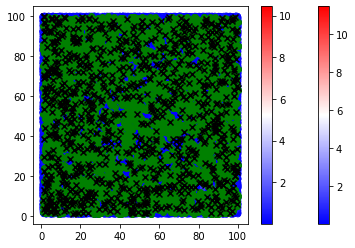

4000 0.037562442177039634 	Loss(validation) = 0.03553466186203205
4100 0.03586127833305258 	Loss(validation) = 0.03583048343099182
4200 0.03461313524238207 	Loss(validation) = 0.03612254879075683
4300 0.03358272825653229 	Loss(validation) = 0.03625475300746833
4400 0.032695700684519824 	Loss(validation) = 0.03631971716590358
4500 0.031910301205123295 	Loss(validation) = 0.03637624190206166
4600 0.031206868184245055 	Loss(validation) = 0.03650186968890978
4700 0.030572017730121907 	Loss(validation) = 0.03654490605248851
4800 0.029978864078088942 	Loss(validation) = 0.03661694363317644
4900 0.02947217176293062 	Loss(validation) = 0.03678961266344152
Assembling residuals...


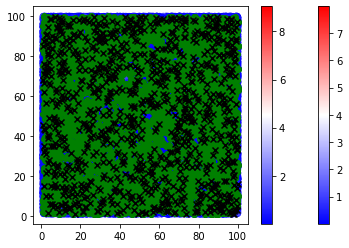

5000 0.034249419047415526 	Loss(validation) = 0.03779804610556574
5100 0.033431147568704606 	Loss(validation) = 0.03769272995163305
5200 0.03247245317380759 	Loss(validation) = 0.03741617117219507
5300 0.03184305001666338 	Loss(validation) = 0.03729968064847182
5400 0.03131143458946597 	Loss(validation) = 0.037212865931277886
5500 0.030738333011142996 	Loss(validation) = 0.03707024275226678
5600 0.03024707498519953 	Loss(validation) = 0.03705812821335369
5700 0.029863704939481414 	Loss(validation) = 0.03704107503618457
5800 0.029455797976680083 	Loss(validation) = 0.036891835472845726
5900 0.02899152967093058 	Loss(validation) = 0.03672113760760758
Assembling residuals...


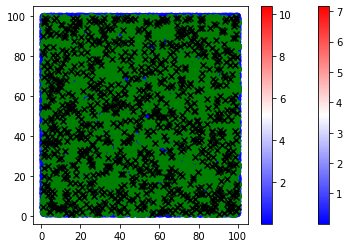

6000 0.03369422136991978 	Loss(validation) = 0.034555238749527886
6100 0.03286736985354248 	Loss(validation) = 0.03423464289158668
6200 0.03226146716613627 	Loss(validation) = 0.03395901586137343
6300 0.0317980623322092 	Loss(validation) = 0.0339302471867887
6400 0.03132101933064885 	Loss(validation) = 0.03368797599945779
6500 0.030877636108118566 	Loss(validation) = 0.033576244367962374
6600 0.030597516730278548 	Loss(validation) = 0.033499162877312354
6700 0.030391116030784777 	Loss(validation) = 0.0339098223435001
6800 0.029777930925389672 	Loss(validation) = 0.033388217638984447
6900 0.02944199580464536 	Loss(validation) = 0.03334729061378029
Assembling residuals...


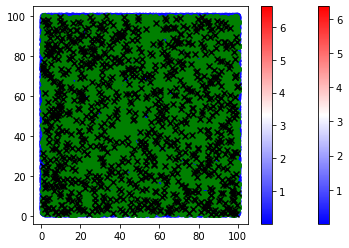

7000 0.03286526411651568 	Loss(validation) = 0.03212012334624624
7100 0.03226962707022985 	Loss(validation) = 0.03173279767322784
7200 0.031741223986792105 	Loss(validation) = 0.03140611459194756
7300 0.03130020223152245 	Loss(validation) = 0.031134252962299724
7400 0.031029211844315764 	Loss(validation) = 0.030880578725214096
7500 0.03066973940256717 	Loss(validation) = 0.03066146880246332
7600 0.030269742329314175 	Loss(validation) = 0.030449967859990355
7700 0.030010262609312537 	Loss(validation) = 0.030228094299884926
7800 0.029807942355649385 	Loss(validation) = 0.030095358697349726
7900 0.02947018437239658 	Loss(validation) = 0.029857075917322052
Assembling residuals...


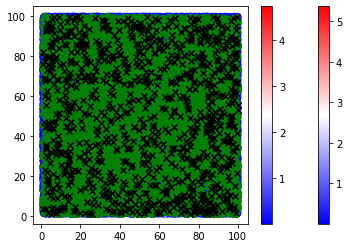

8000 0.03179171687976042 	Loss(validation) = 0.02786108439717688
8100 0.03175091794613017 	Loss(validation) = 0.028228559373600127
8200 0.031019793575500165 	Loss(validation) = 0.0276793683050074
8300 0.030563665559292283 	Loss(validation) = 0.027493709795122997
8400 0.030261959536329774 	Loss(validation) = 0.02744076901890197
8500 0.029985123874870317 	Loss(validation) = 0.02735294087065843
8600 0.029729483139534673 	Loss(validation) = 0.02729994675195497
8700 0.029488528934980704 	Loss(validation) = 0.02725776898943986
8800 0.029412463845440603 	Loss(validation) = 0.027306257975257892
8900 0.029270105381718682 	Loss(validation) = 0.02750673049971987
Assembling residuals...


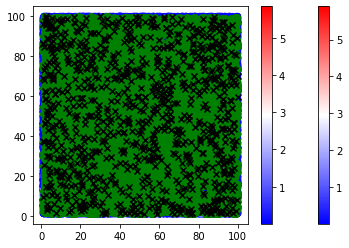

9000 0.03062333354257943 	Loss(validation) = 0.02659804751595956
9100 0.03018569471080859 	Loss(validation) = 0.026461798848543154
9200 0.029965368161999722 	Loss(validation) = 0.02646596046231856
9300 0.029658999973348178 	Loss(validation) = 0.02624555534751331
9400 0.029493211604916535 	Loss(validation) = 0.026223939020042938
9500 0.02936216155593241 	Loss(validation) = 0.02620806682445054
9600 0.029040212746484845 	Loss(validation) = 0.026033813091554604
9700 0.028874009787915326 	Loss(validation) = 0.025987671602546534
9800 0.028662105781806793 	Loss(validation) = 0.02592894560600841
9900 0.028517810635335126 	Loss(validation) = 0.02590559240692451


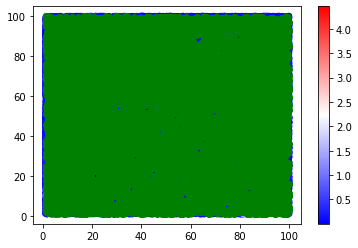

In [9]:
n = 100000 # number of parameters for which we compute residuals each iteration
num_new_params = 1000 # number of parameters with which we augment data each iteration

# train PDNN
print("Initial training...")
pdnn_trainer.train()




print("Beginning data augmentation cycles...")
for i in range(9):
    new_parameters = pdnn_net.augment_parameters_with_time(
        RONNData.get_new_parameters(pdnn_net, n)
    )

    print("Assembling residuals...")
    residuals, _, loss_functions = ErrorAnalysis.get_residuals(
        pdnn_net, data, new_parameters, 
        input_normalization_pdnn, output_normalization_pdnn,
        plot_residuals=True
    )

    probabilities = residuals
    probabilities /= np.sum(probabilities)
    sample_indices = np.random.choice(residuals.shape[0], size=residuals.shape[0],
                                      replace=False, p=probabilities)
    #cumulative_probs = np.cumsum(probabilities[sample_indices])
    #last_index = np.searchsorted(cumulative_probs, 0.25) + 1
    #sample_indices = sample_indices[:last_index]
    #sample_indices = np.argsort(-probabilities)
    sample_indices = sample_indices[:num_new_params]
    high_residual_params = new_parameters[sample_indices]
    plt.scatter(high_residual_params[:, 0].numpy().reshape(-1), 
                high_residual_params[:, 1].numpy().reshape(-1), marker='x', color='black')
    
    plt.show()
    
    # solve reduced PDE system for parameters found above and augment training data
    for j, mu in enumerate(high_residual_params):
        reduced_problem.set_mu(tuple(np.array(mu)))
        reduced_problem.solve()
        solution = torch.tensor(np.array(reduced_problem._solution.vector()[:])).view(-1, 1)
        pdnn_loss.concatenate_snapshots(solution)
        
    data.train_data = torch.cat([data.train_data, high_residual_params])
    
    # train PDNN
    pdnn_trainer.train()
    
    residuals, _, _ = ErrorAnalysis.get_residuals(
        pdnn_net, data, new_parameters, 
        input_normalization_pdnn, output_normalization_pdnn,
        loss_functions, plot_residuals=True
    )

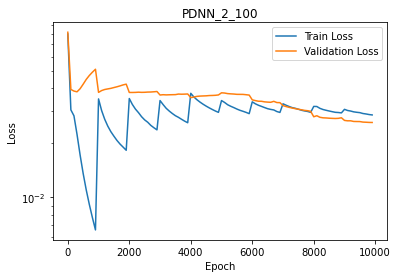

In [10]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.3 Train PRNN

In [17]:
input_normalization_prnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_prnn = Normalization.MinMaxNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=100)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=11250)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [18]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 5.740627825377074 	Loss(validation) = 4.08577647768821
100 0.07445572636207465 	Loss(validation) = 0.08246060523127699
200 0.06330032883355473 	Loss(validation) = 0.07128775246708247
300 0.059553269753550575 	Loss(validation) = 0.06748652352592506
400 0.057747208404755855 	Loss(validation) = 0.06568755147174614
500 0.05638657200056889 	Loss(validation) = 0.06436416206097306
600 0.05518013776899511 	Loss(validation) = 0.06320196308030102
700 0.054037976472352894 	Loss(validation) = 0.06210891994476804
800 0.05291067211383549 	Loss(validation) = 0.061041414377524195
900 0.05176995059463446 	Loss(validation) = 0.05998046620285989
1000 0.050607167575207224 	Loss(validation) = 0.05892593716332081
1100 0.049429660776317275 	Loss(validation) = 0.05788836313310584
1200 0.04825295172497998 	Loss(validation) = 0.05688110026502603
1300 0.047115374928432395 	Loss(vali

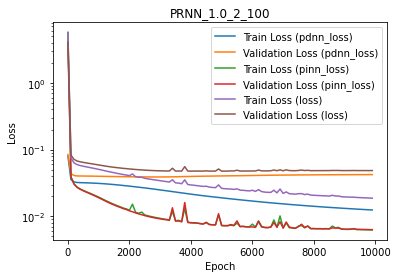

In [19]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

#### 4.5.4 Train PINN

In [11]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN(f"PINN", problem, reduction_method, n_hidden=2, n_neurons=100)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2,
                                    num_without_snapshots=11750)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [12]:
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 7.945496310330034 	Loss(validation) = 5.252110380818222
100 0.04282982429048961 	Loss(validation) = 0.04349353220958282
200 0.03265658410063579 	Loss(validation) = 0.03346416939692835
300 0.028373657350069036 	Loss(validation) = 0.02923968224075912
400 0.02608218111671107 	Loss(validation) = 0.026984991784589477
500 0.02466399270001524 	Loss(validation) = 0.025582488247717316
600 0.023623450750362162 	Loss(validation) = 0.024543827563149125
700 0.022761098685378938 	Loss(validation) = 0.023676962711079327
800 0.021998414683340073 	Loss(validation) = 0.02290640566056134
900 0.021299133449071937 	Loss(validation) = 0.022196402779537293
1000 0.020641928509303027 	Loss(validation) = 0.02152531414929007
1100 0.020011167701423867 	Loss(validation) = 0.02087713821173321
1200 0.019392972121128033 	Loss(validation) = 0.020237755233568227
1300 0.018773587587177933 	

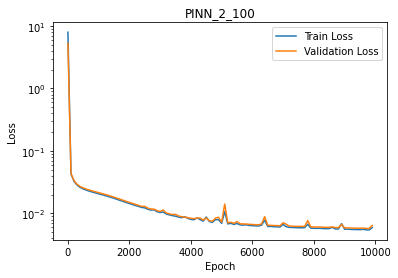

In [13]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

### 4.6. Perform an error analysis

In the results below, the absolute error is on the order of $10^{-2}$, while the relative error is on the order of $10^{-1}$. In each case, the NN-HF error is roughly 100 times larger than the RO-HF error.

In [14]:
np.random.seed(42)
reduction_method.initialize_testing_set(100)
test_mu = torch.tensor(reduction_method.testing_set)

#### 4.6.1 Greedy PDNN-PINN Error Analysis

In [15]:
pdnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn, relative=False
)

#################################### N = 52 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.004270574595104698	0.004269007100101049	5.386475717194563e-05
mean	0.02614646540461167	0.026129214030677347	0.00040665682645036054
max	0.0936720834452356	0.09320563645631945	0.003227222308663739


#### 4.6.2 PRNN Error Analysis

In [20]:
prnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn, relative=False
)

#################################### N = 52 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.002940546782370971	0.0029380750383925266	5.386475717194563e-05
mean	0.03283056621842487	0.03279950206466674	0.00040665682645036054
max	0.17587612110702466	0.17590619280978403	0.003227222308663739


#### 4.6.3 PINN Error Analysis

In [16]:
pinn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn, relative=False
)

#################################### N = 52 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0017443572061243352	0.0017396919619981563	5.386475717194563e-05
mean	0.032961587803438	0.032927635709515075	0.00040665682645036054
max	0.1535122814806525	0.15354110607385235	0.003227222308663739
